# hope this helps with understanding how XGB and LGBM was used together for high score result.
**If you find this helpful please upvote & maybe leave a comment, would help alot :)**

## Loading libraries and Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
import warnings
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## Data Analysis

In [4]:
#can be used if we import pandas_profiling as pp
#pp.ProfileReport(train)

In [5]:
#Seprate taget value "Id" "Loan_status(more importantly)" from the features
y = train[['id','loan_status']]
#After storing the target value "loan_status" in y we can now drop it from the feature set 
train = train.drop("loan_status", axis=1)

print("dropped")

dropped


In [6]:
#creates a list with both Training and Testing Data sets -> all_dfs
all_dfs = [train,test]
# "d.concat(all_dfs)" merges the train and test datasets into a single DataFrame called all_df. It stacks them vertically by default since they share the same columns.
# ".reset_index(drop=True)" resets the index of the new concatenated DataFrame and drops the old index. 
# Without this, the concatenated DataFrame would retain the indices from both train and test
all_df = pd.concat(all_dfs).reset_index(drop=True)
#we combine both data set first to be able to handle the data on both set at the same time

In [7]:
all_df.isnull().sum()
#no null values was found no need to fill rows or drop columns

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [8]:
#check all the data types in the data set
print(all_df.dtypes)

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


## Handling Data

In [9]:
#Using labelencoder from Ssklearn to convert "categorical features" to to a numerical format
#This step is essential before feeding the data into Machine Learning models since they work better with numerical input
labelencoder=LabelEncoder()

all_df['person_home_ownership']  = labelencoder.fit_transform(all_df['person_home_ownership'])
all_df['loan_intent']            = labelencoder.fit_transform(all_df['loan_intent'])
all_df['loan_grade']             = labelencoder.fit_transform(all_df['loan_grade'])
all_df['cb_person_default_on_file']      = labelencoder.fit_transform(all_df['cb_person_default_on_file'])
print(all_df.dtypes)

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership           int64
person_emp_length             float64
loan_intent                     int64
loan_grade                      int64
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file       int64
cb_person_cred_hist_length      int64
dtype: object


In [10]:
#check the data lenght to split the data accoriding back into a traiining set and testing set
print(len(train), len(test), len(all_df))

58645 39098 97743


In [11]:
#scales features by removing the mean
Scaler = StandardScaler()
# ".fit_transform()" calculates the mean and standard deviation for scaling and then applies the transformation to the entire dataset (all_df)
all_scaled   = pd.DataFrame(Scaler.fit_transform(all_df))
#spliting th data into 50/50 :1460 -> firt 1460, 1460:2920 -> second 1460.
#as the training set consists of the first 1460 rows (train_scaled), while the test set is the next 1460 rows (test_scaled)
#train_scaled: This represents the feature set after feature scaling, which contains all the predictors (i.e., features)
train_scaled = pd.DataFrame(all_scaled[:58645])
test_scaled  = pd.DataFrame(all_scaled[58645:97743])

In [12]:
X = train_scaled
X_train, X_test, y_train, y_test = train_test_split(X, y['loan_status'], test_size=0.1, random_state=42)

## XGBboost

In [13]:
from xgboost import XGBRegressor
XGB = XGBRegressor(
    max_depth=2,       #maximum depth tree (Limits the depth of each decision tree to prevent overfitting)
    learning_rate=0.1, #step size to update the weight after each boosting step (Controls how much the model adjusts during each boosting step)
    n_estimators=1000, #number of trees or "boosting rounds"
    reg_alpha=0.001,   #regulization term on weights
    reg_lambda=0.000001,
    n_jobs=-1,         #uses all availible CPU 
    min_child_weight=3 #minimum sum of instance weights required in a child note
)                      #^^(A higher value makes the model more conservative by preventing the tree from growing too complex )
XGB.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

## LGBM

In [14]:
from lightgbm import LGBMRegressor
#initialize model
#n_estimators=1000 specifies that the model will build 1000 boosting iterations or "trees"
LGBM = LGBMRegressor(n_estimators = 1000)
LGBM.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 52780, number of used features: 12
[LightGBM] [Info] Start training from score 0.142592


LGBMRegressor(n_estimators=1000)

## Test scores

In [15]:
#Test score for both models 
print ("Training score:",XGB.score(X_train,y_train), "Test Score:",XGB.score(X_test,y_test))
print ("Training score:",LGBM.score(X_train,y_train),"Test Score:",LGBM.score(X_test,y_test))

Training score: 0.6165753447534977 Test Score: 0.6059599462816594
Training score: 0.8393210818318849 Test Score: 0.6710494752023524


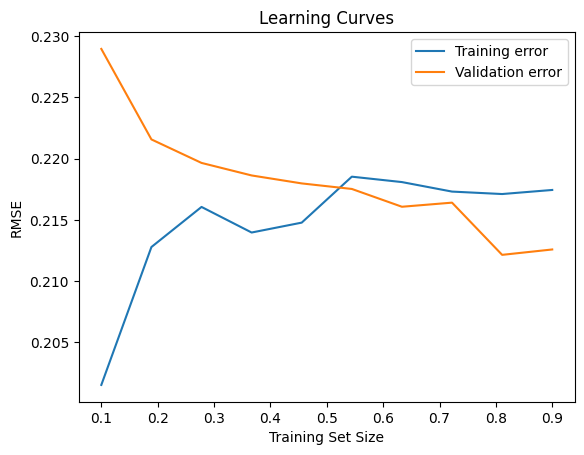

In [16]:
#plottoing a learning curve to seee if our model is overfiting 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

train_sizes = np.linspace(0.1, 0.9, 10)
train_errors = []
validation_errors = []
    
# For each training size, train the model and evaluate performance
for train_size in train_sizes:
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
    
    XGB.fit(X_train_subset, y_train_subset)
    
    y_train_pred = XGB.predict(X_train_subset)
    y_val_pred = XGB.predict(X_test_subset)
    
    # Compute errors
    train_rmse = mean_squared_error(y_train_subset, y_train_pred, squared=False)
    val_rmse = mean_squared_error(y_test_subset, y_val_pred, squared=False)
    
    train_errors.append(train_rmse)
    validation_errors.append(val_rmse)

# Plot learning curves
plt.plot(train_sizes, train_errors, label='Training error')
plt.plot(train_sizes, validation_errors, label='Validation error')
plt.ylabel('RMSE')
plt.xlabel('Training Set Size')
plt.title('Learning Curves')
plt.legend()
plt.show()

## Submission 

In [17]:
#generate the predictions using ".predict" for the "test_scaled" for both models and store it to merge later
y_pred_xgb  = pd.DataFrame( XGB.predict(test_scaled))
y_pred_lgbm = pd.DataFrame(LGBM.predict(test_scaled))
#create empty dataset set to store the result (with the same format as the sample_submission)
y_pred=pd.DataFrame()
#store the "loan_status" prediction from both XGB and LGBM 
#the loan_status was combines by dividng each value from each model half and then added together
y_pred['loan_status'] = 0.5 * y_pred_xgb[0] + 0.5 * y_pred_lgbm[0]
#store the Id column in the dataset
y_pred['id'] = test['id']

In [18]:
#save dataset into a csv file for submission
y_pred.to_csv('submission.csv',index=False)

Here an XGB and LGBm reggrosion model were used as the Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets. Howver a XGB and LGBM classification model would usually give higher accuracy but not lower test score.

**PS** : you can try this yourself and see the results by changing the models from 

* > from xgboost import XGBRegressor \
  > XGB = XGBRegressor( 

**too** 

* > from xgboost import XGBClassifier\
  > XGB = XGBClassifier( 

And same thing the LGBM\
hope this was clear enough and easy to understand, if something doesnt seem clear enough or confusing drop a comment I would be more than happy to help and explain more
